In [1]:
import os
import numpy as np
import torch

from torch.utils.data import DataLoader, Subset
from torchvision import datasets
from torchvision import transforms
from torchvision.ops import DropBlock2d
import torch.nn as nn

from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt

%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
classes = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']
classes_dict = {i : classes[i] for i in range(len(classes))}

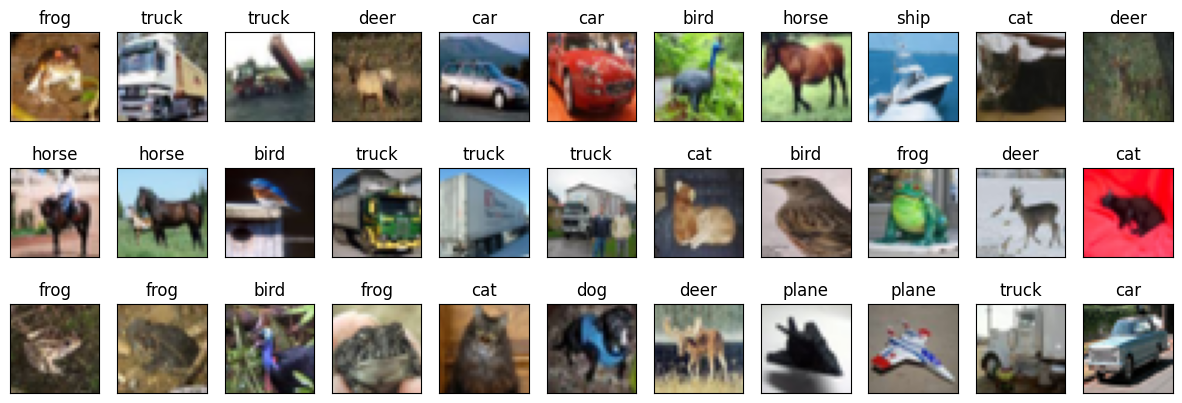

In [3]:
# Definimos a transformação que vai ser aplicada aos dados: transformar em tensores
transf = transforms.Compose([transforms.ToTensor()])

# Vamos utilizar a implementação do CIFAR10 diretamente do Pytorch
train_set = datasets.CIFAR10('/pgeoprj2/ciag2024/dados/cifar', transform=transf, train=True, download=False)
test_set = datasets.CIFAR10('/pgeoprj2/ciag2024/dados/cifar', transform=transf, train=False, download=False)

# Plotando exemplos de imagens do conjunto de treino.
fig, ax = plt.subplots(3, 11, figsize=(15, 5))

idx = 0
for i in range(3):
    for j in range(11):

        ax[i][j].imshow(train_set[idx][0].numpy().transpose((1,2,0)).squeeze())
        ax[i][j].set_title(classes_dict[train_set[idx][1]])
        ax[i][j].set_yticks([])
        ax[i][j].set_xticks([])
        idx += 1

plt.show()

In [4]:
# Para gerar o conjunto de validação, vamos separar 10% do conjunto de treino
train_indices, val_indices, _, _ = train_test_split(
    range(len(train_set)), # índice das N imagens do dataset
    train_set.targets, # rótulos das imagens
    stratify=train_set.targets, #  os rótulos serão usados pela função para fazer uma divisão proporcional entre as classes
    test_size=0.1, # separamos 10% do conjunto para a validação
    random_state=42
)

# Geramos um subsets dos dados conforme os índices gerados pelo split
train_split = Subset(train_set, train_indices)
val_split = Subset(train_set, val_indices)

# Criando os dataloaders
batch_size = 64

train_loader = DataLoader(train_split, batch_size, shuffle=True)
val_loader = DataLoader(val_split, batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size, shuffle=False)

print('Número de mini-batches no treino: ', len(train_loader))
print('Número de mini-batches na validação: ', len(val_loader))
print('Número de mini-batches no teste: ', len(test_loader))

Número de mini-batches no treino:  704
Número de mini-batches na validação:  79
Número de mini-batches no teste:  157


In [5]:
class DoubleConvolution(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 3, padding = 1)
        self.bnorm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size = 3, padding = 1)
        self.bnorm2 = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()

        self.operation = nn.Sequential(
            self.conv1, self.bnorm1, self.activation, self.conv2, self.bnorm2, self.activation
        )
            

    def forward(self, x):

        x = self.operation(x)

        return x


class ToyNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.pooling = nn.MaxPool2d(kernel_size=2, stride = 2)
        self.double_convolution1 = DoubleConvolution(in_channels = 3, out_channels = 64)
        self.double_convolution2 = DoubleConvolution(in_channels = 64, out_channels = 128)
        self.double_convolution3 = DoubleConvolution(in_channels = 128, out_channels = 256)
        self.conv_kernel1 = nn.Sequential(
                nn.Conv2d(in_channels = 256, out_channels = 32, kernel_size=1),
                nn.ReLU()
        )
        
        self.num_classes = 10
        output_size = int(32* 8*8)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(output_size, output_size // 2),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(output_size // 2, self.num_classes)
        )
        self.drop = DropBlock2d(block_size=3, p=0.2)
        
    def forward(self, x):

        x = self.double_convolution1(x) # (3, 32, 32) -> (64, 32, 32)
        x = self.drop(x)
        x = self.pooling(x) # (64, 32, 32) -> (64, 16, 16)
        x = self.double_convolution2(x) # (64, 16, 16) -> (128, 16, 16)
        x = self.drop(x)
        x = self.pooling(x) # (128, 16, 16) -> (128, 8, 8)
        x = self.double_convolution3(x) # (128, 8, 8) -> (256, 8, 8)
        x = self.conv_kernel1(x) # (256, 8, 8) ->  (32, 8, 8)
        x = self.classifier(x) # (32*8*8) -> (10)

        return x 

In [6]:
num_epochs, lr, weight_decay = 20, 0.001, 0.0001

In [7]:
model = ToyNetwork().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [8]:
%matplotlib inline

epochs = 20

train_loss = np.zeros(epochs)
train_acc = np.zeros(epochs)
val_loss = np.zeros(epochs)
val_acc = np.zeros(epochs)

for ep in range(epochs):

    print('##############################################')
    print('Starting epoch ' + str(ep + 1) + '/' + str(epochs) + '...')

    print('Training...')

    # Colocando o modelo no modo de treinamento
    model.train()

    training_metrics = list()
    val_metrics = list()

    train_label_list = list()
    train_output_list = list()

    # Iterando nos batches de treino
    for it, data in enumerate(train_loader):

        # Obtendo o dado (inps) e rótulo (labs) do batch
        inps, labs = data

        # GPU casting
        inps = inps.cuda()
        labs = labs.cuda()

        # Zerando o otimizador
        optimizer.zero_grad()

        # Realizando o forward
        output = model(inps)

        # Computando a loss
        loss = criterion(output, labs)

        # Realizando o Backpropagation
        loss.backward()

        # Atualizando os pesos da rede
        optimizer.step()

        # Adicionando a loss do batch na lista
        training_metrics.append(loss.detach().cpu().numpy())

        # Pegando a previsão e o label do batch para calculo da acurácia ao final da época
        train_label_list += labs.cpu().numpy().tolist()
        train_output_list += output.max(1)[1].cpu().numpy().tolist()

    # Calculando a acurácia de treino na época
    train_label_array = np.asarray(train_label_list, dtype=np.int32).ravel()
    train_output_array = np.asarray(train_output_list, dtype=np.int32).ravel()
    accuracy = np.sum(train_label_array == train_output_array) / float(train_label_array.shape[0])
    print('\tTrain Accuracy: %.2f%%' % (100.0 * accuracy))

    # Adicionando a acurácia e loss aos respectivos arrays para plotar no final do treino
    train_acc[ep] = accuracy
    train_loss[ep] = np.asarray(training_metrics).ravel().mean()

    print('Validation...')

    # Colocando o modelo no modo de validação
    model.eval()

    with torch.no_grad():

        label_list = list()
        output_list = list()

        # Iterando sobre os batches de validação
        for it, data in enumerate(val_loader):

            # Obtendo o dado e rótulo do batch
            inps, labs = data

            # GPU casting
            inps = inps.cuda()
            labs = labs.cuda()

            # Forward
            output = model(inps)

            # Computando a loss
            loss = criterion(output, labs)

            # Adicionando a loss do batch na lista
            val_metrics.append(loss.detach().cpu().numpy())

            # Pegando a previsão e rótulo do batch para cálculo de acurácia
            label_list += labs.cpu().numpy().tolist()
            output_list += output.max(1)[1].cpu().numpy().tolist()

        # Calculando a acurácia da validação na época
        label_array = np.asarray(label_list, dtype=np.int32).ravel()
        output_array = np.asarray(output_list, dtype=np.int32).ravel()
        accuracy = np.sum(label_array == output_array) / float(label_array.shape[0])
        print('\tValidation Accuracy: %.2f%%' % (100.0 * accuracy))

        # Adicionando acurácia e loss aos respectivos arrays para plotar no final
        val_acc[ep] = accuracy
        val_loss[ep] = np.asarray(val_metrics).ravel().mean()

##############################################
Starting epoch 1/20...
Training...
	Train Accuracy: 50.26%
Validation...
	Validation Accuracy: 64.42%
##############################################
Starting epoch 2/20...
Training...
	Train Accuracy: 68.19%
Validation...
	Validation Accuracy: 71.04%
##############################################
Starting epoch 3/20...
Training...
	Train Accuracy: 74.13%
Validation...
	Validation Accuracy: 67.28%
##############################################
Starting epoch 4/20...
Training...
	Train Accuracy: 78.04%
Validation...
	Validation Accuracy: 77.74%
##############################################
Starting epoch 5/20...
Training...
	Train Accuracy: 80.92%
Validation...
	Validation Accuracy: 78.08%
##############################################
Starting epoch 6/20...
Training...
	Train Accuracy: 83.40%
Validation...
	Validation Accuracy: 79.70%
##############################################
Starting epoch 7/20...
Training...
	Train Accuracy: 84.84%


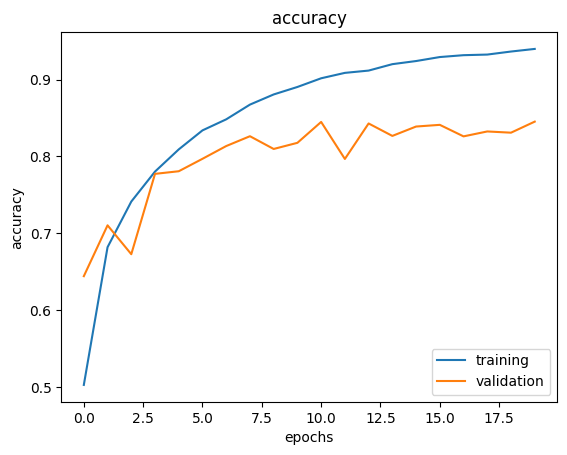

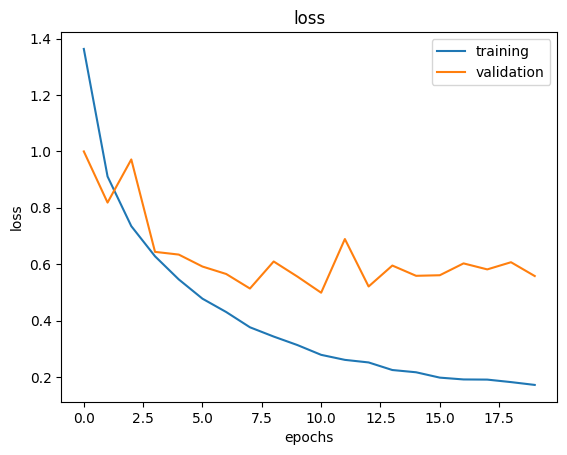

In [9]:
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['training', 'validation'], loc='lower right')
plt.show()

plt.plot(train_loss)
plt.plot(val_loss)
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [10]:
from matplotlib import pyplot as plt
from torch.autograd import Variable

%matplotlib inline

print('Test...')

model.eval()

with torch.no_grad():

    label_list = list()
    output_list = list()

    for it, data in enumerate(test_loader):
        inps, labs = data

        inps = inps.cuda()
        labs = labs.cuda()

        output = model(inps)

        label_list += labs.cpu().numpy().tolist()
        output_list += output.max(1)[1].cpu().numpy().tolist()

    label_array = np.asarray(label_list, dtype=np.int32).ravel()
    output_array = np.asarray(output_list, dtype=np.int32).ravel()

    accuracy = np.sum(label_array == output_array) / float(label_array.shape[0])
    print('Test Accuracy: %.2f%%' % (100.0 * accuracy))

Test...
Test Accuracy: 83.66%


Image shape:  torch.Size([3, 32, 32])
Image shape after unsqueeze:  torch.Size([1, 3, 32, 32])
Prediction:  plane  | Label:  plane


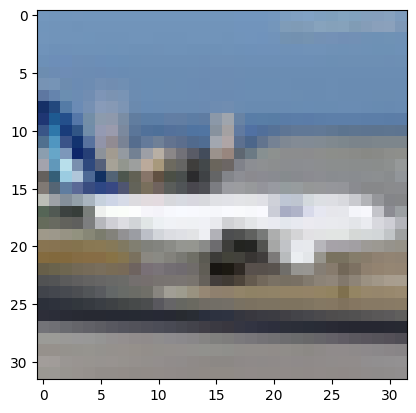

In [11]:
id_img = 90
img, label = test_set[id_img]
plt.imshow(img.numpy().transpose((1,2,0)))
print('Image shape: ', img.shape)
img = img.unsqueeze(0)
print('Image shape after unsqueeze: ', img.shape)
img = img.cuda()
predicao = model(img)
print('Prediction: ', classes_dict[predicao.max(1)[1].cpu().item()], ' | Label: ', classes_dict[label])